In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [33]:
feature = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
submit = pd.read_csv("sampleSubmission.csv")

In [34]:
df_test["Dept"].max()

99

### 学習データ
- 店舗データに関しては、1~45の45店舗分
- カテゴリデータに関しては、1~99の81カテゴリ分
- 2010-02-05~2012-10-26の143週間分

### テストデータ
- 2012-11-02~2013-07-26の39週間分

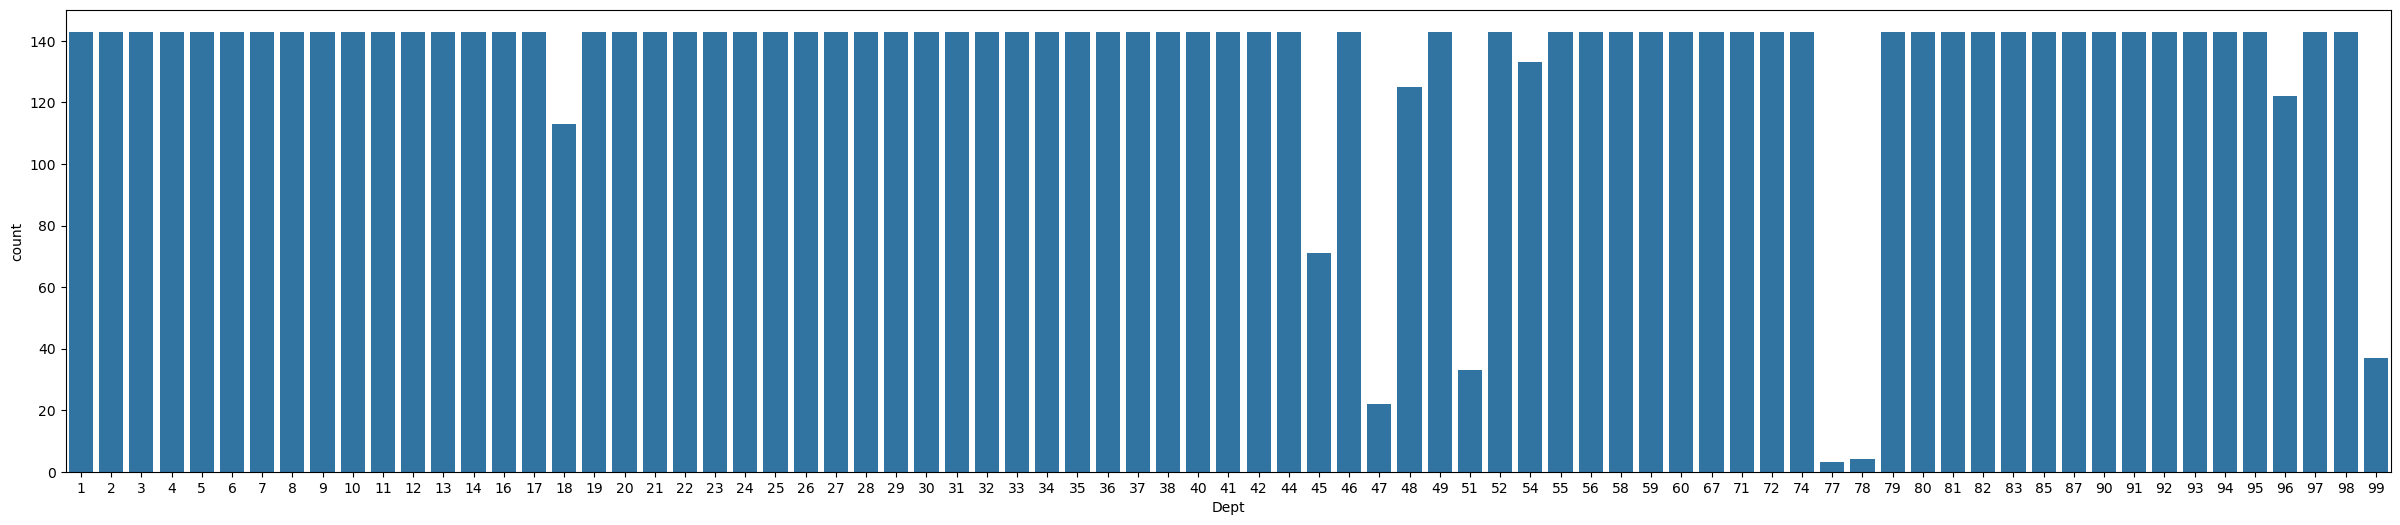

In [35]:
#店舗１の部門（カテゴリ）別のデータ数
plt.figure(figsize=(30,6))
sns.countplot(x="Dept", data=df_train[df_train["Store"] == 1])
plt.show()

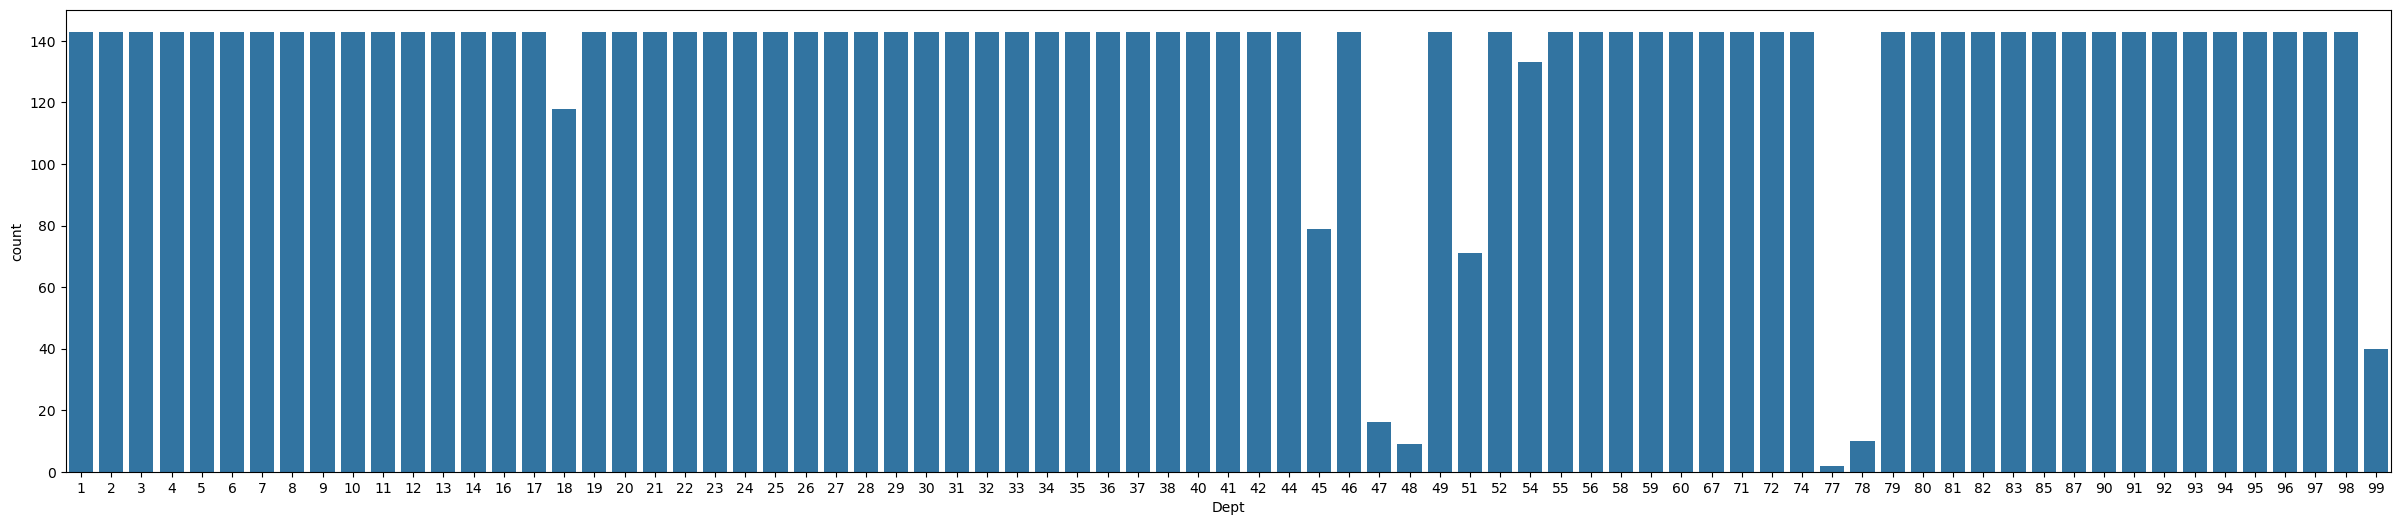

In [5]:
#他店舗の部門（カテゴリ）別のデータ数
plt.figure(figsize=(30,6))
sns.countplot(x="Dept", data=df_train[df_train["Store"] == 32])
plt.show()

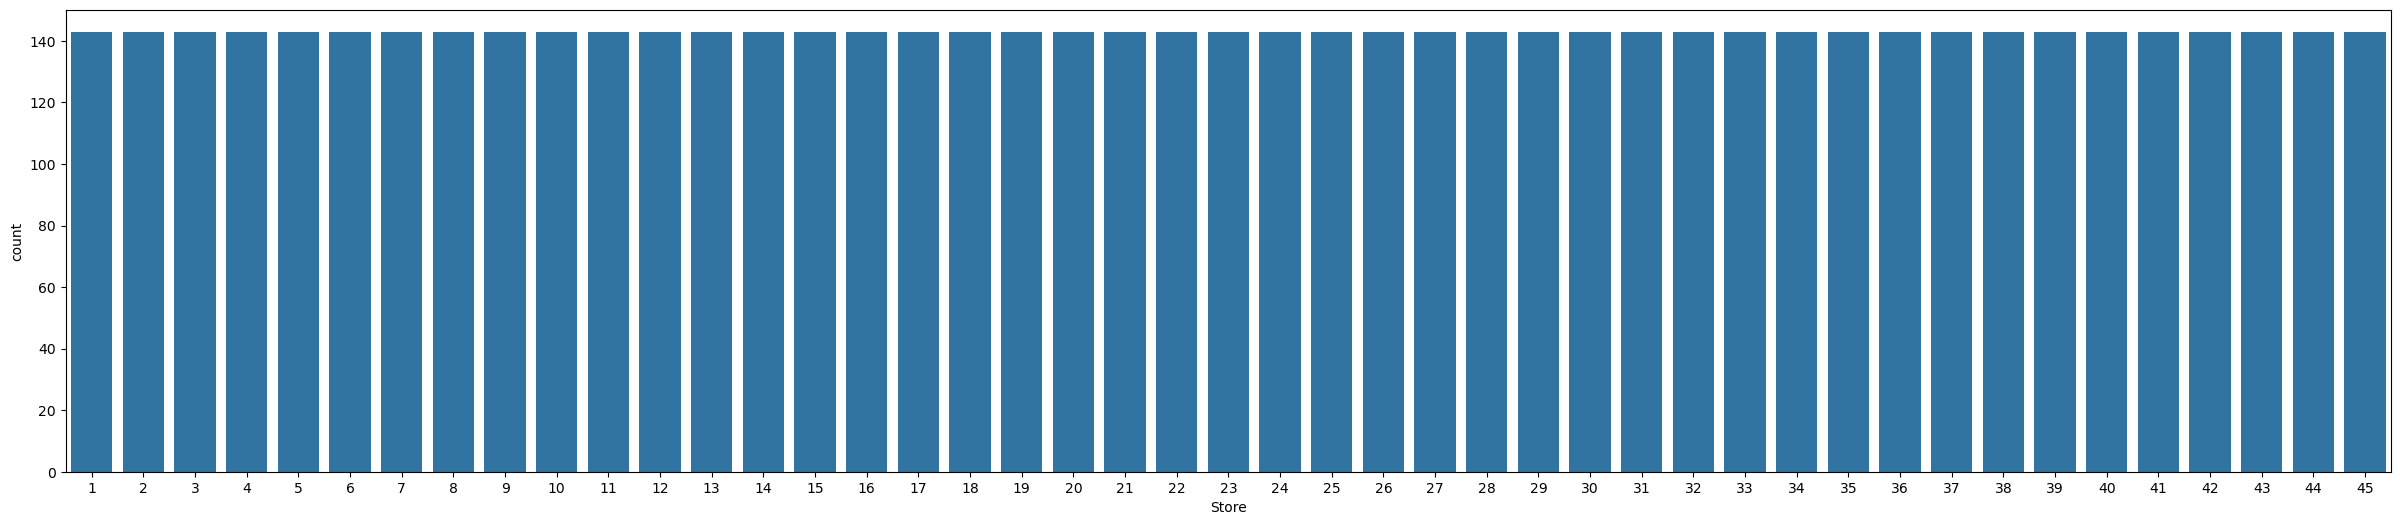

In [6]:
# カテゴリ1の店舗別のデータ数
plt.figure(figsize=(30,6))
sns.countplot(x="Store", data=df_train[df_train["Dept"] == 1])
plt.show()

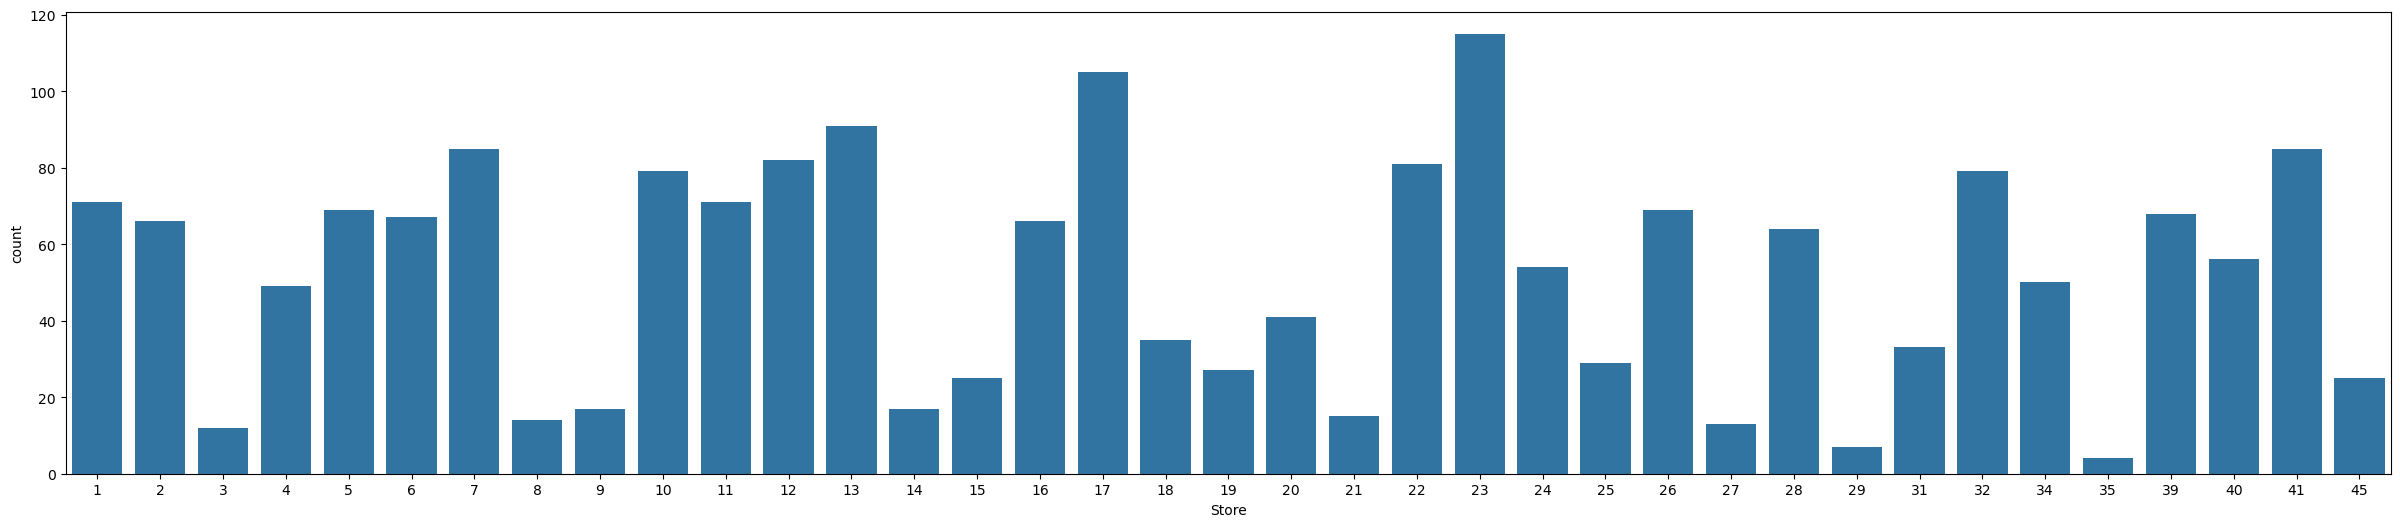

In [7]:
# カテゴリ45の店舗別のデータ数
plt.figure(figsize=(30,6))
sns.countplot(x="Store", data=df_train[df_train["Dept"] == 45])
plt.show()

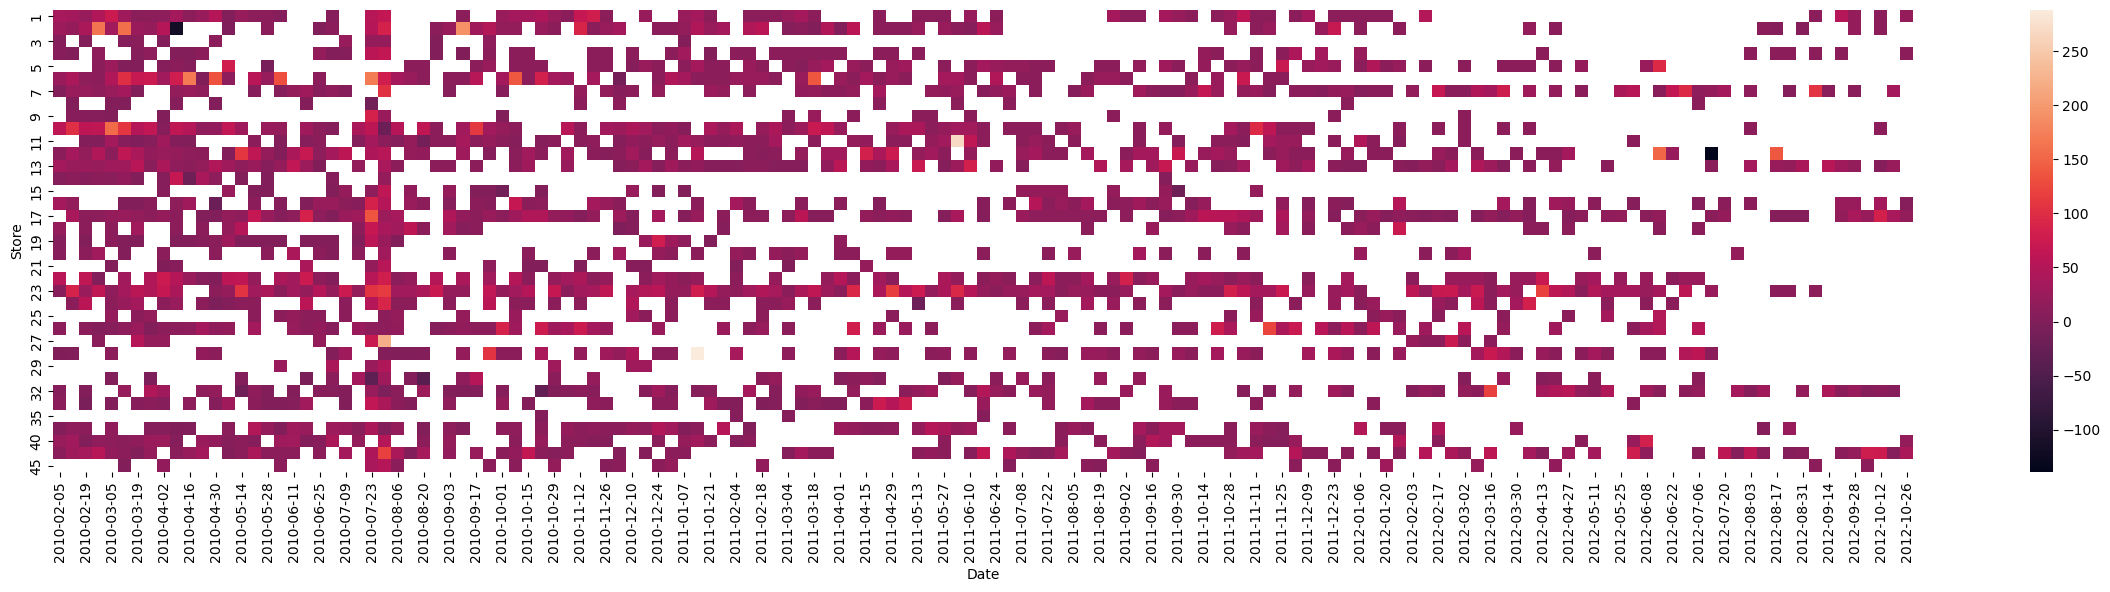

In [8]:
# カテゴリ45の売上データを店舗ごと日別に可視化
plt.figure(figsize=(30,6))
sns.heatmap(pd.pivot_table(df_train[df_train["Dept"] == 45], index="Store", columns="Date", values="Weekly_Sales"))
plt.show()

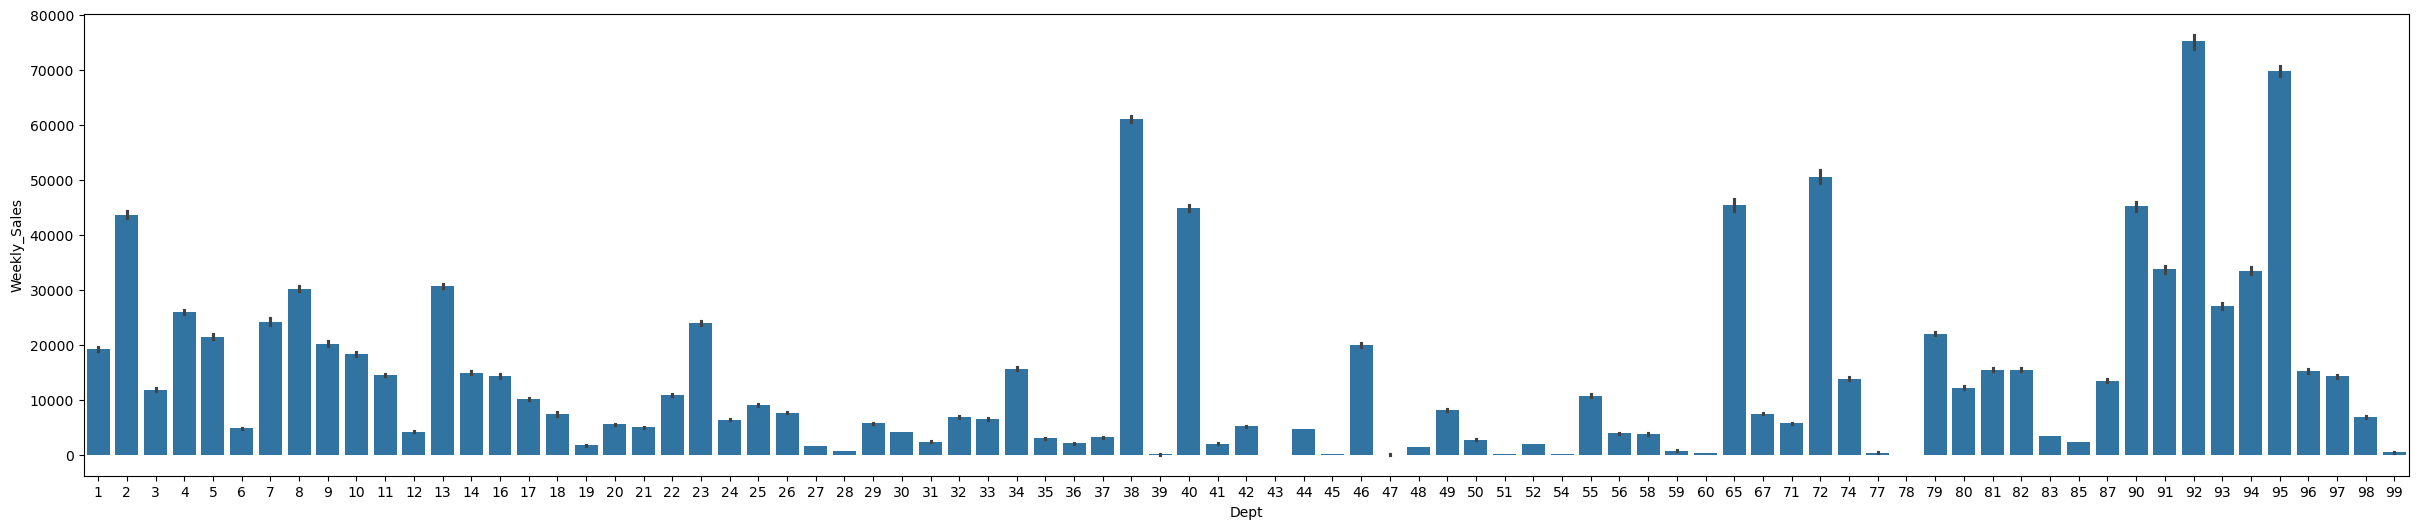

In [9]:
# カテゴリ別の週売上の平均
plt.figure(figsize=(30,6))
sns.barplot(x="Dept", y="Weekly_Sales", data=df_train)
plt.show()

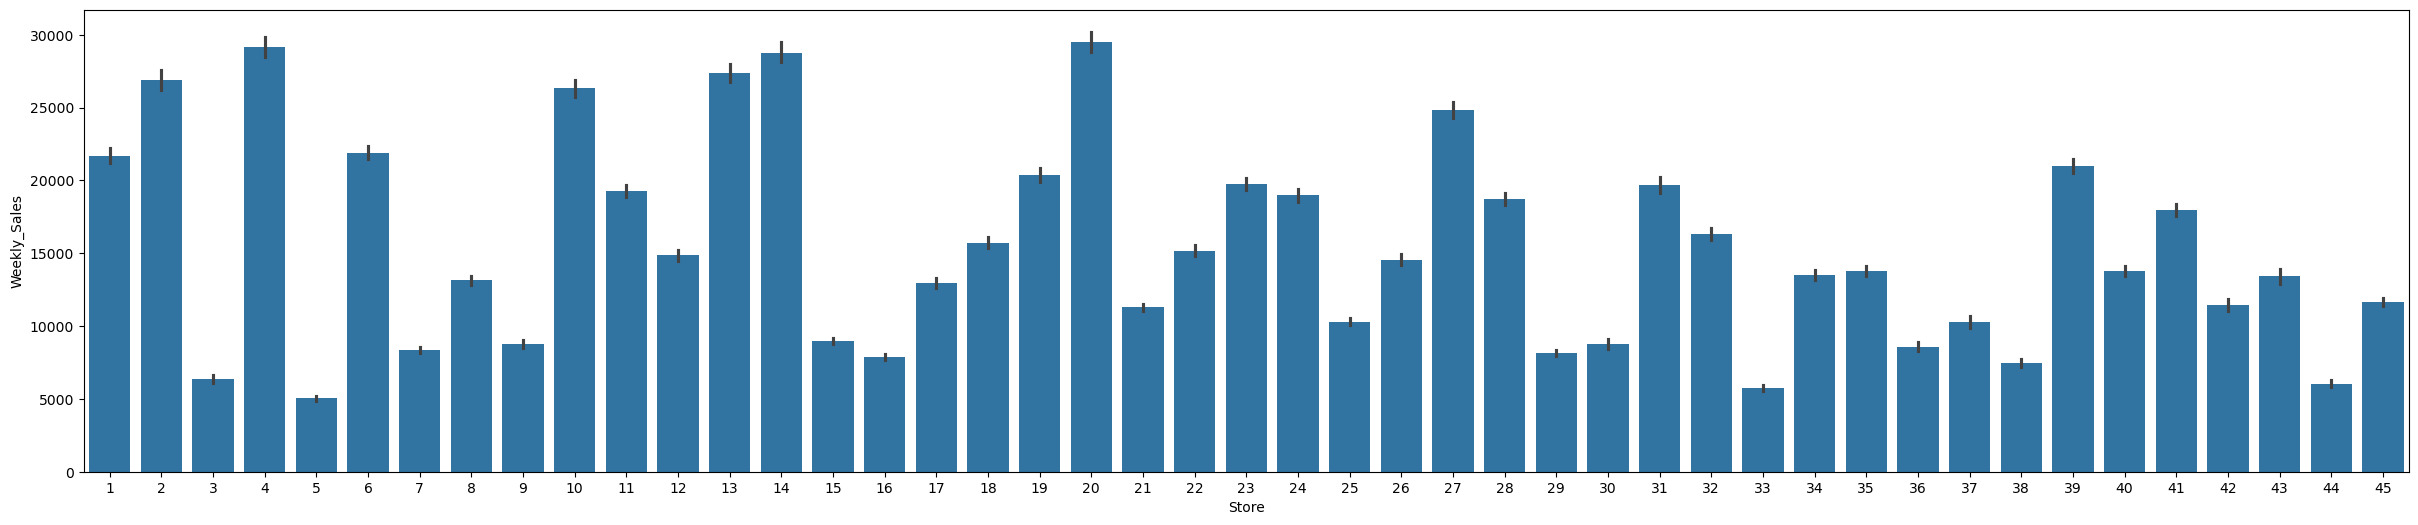

In [10]:
#店舗別の週売上の平均
plt.figure(figsize=(30,6))
sns.barplot(x="Store", y="Weekly_Sales", data=df_train)
plt.show()

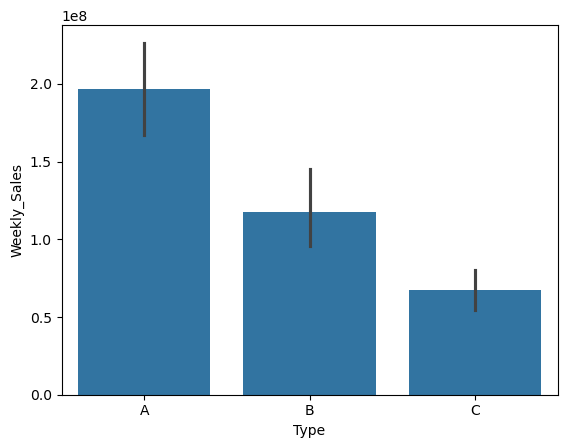

In [11]:
# 店舗タイプ別の売上
df_tmp = pd.merge(df_train.groupby("Store").sum()[["Weekly_Sales"]].reset_index(), stores)
sns.barplot(x="Type", y="Weekly_Sales", data=df_tmp)
plt.show()

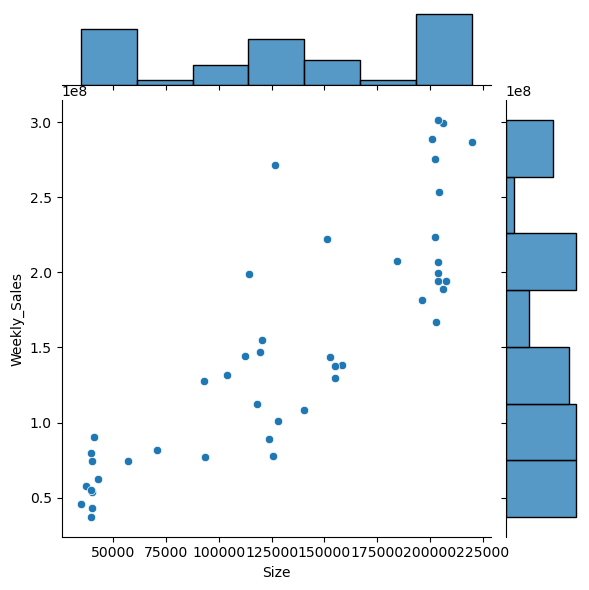

In [12]:
# 店舗サイズ別の売上
sns.jointplot(x="Size", y="Weekly_Sales", data=df_tmp)
plt.show()

In [13]:
df_tmp.drop("Type",axis=1).corr()

,Store,Weekly_Sales,Size
Store,1.00000,-0.350100,-0.244270
Weekly_Sales,-0.35010,1.000000,0.846161
Size,-0.24427,0.846161,1.000000


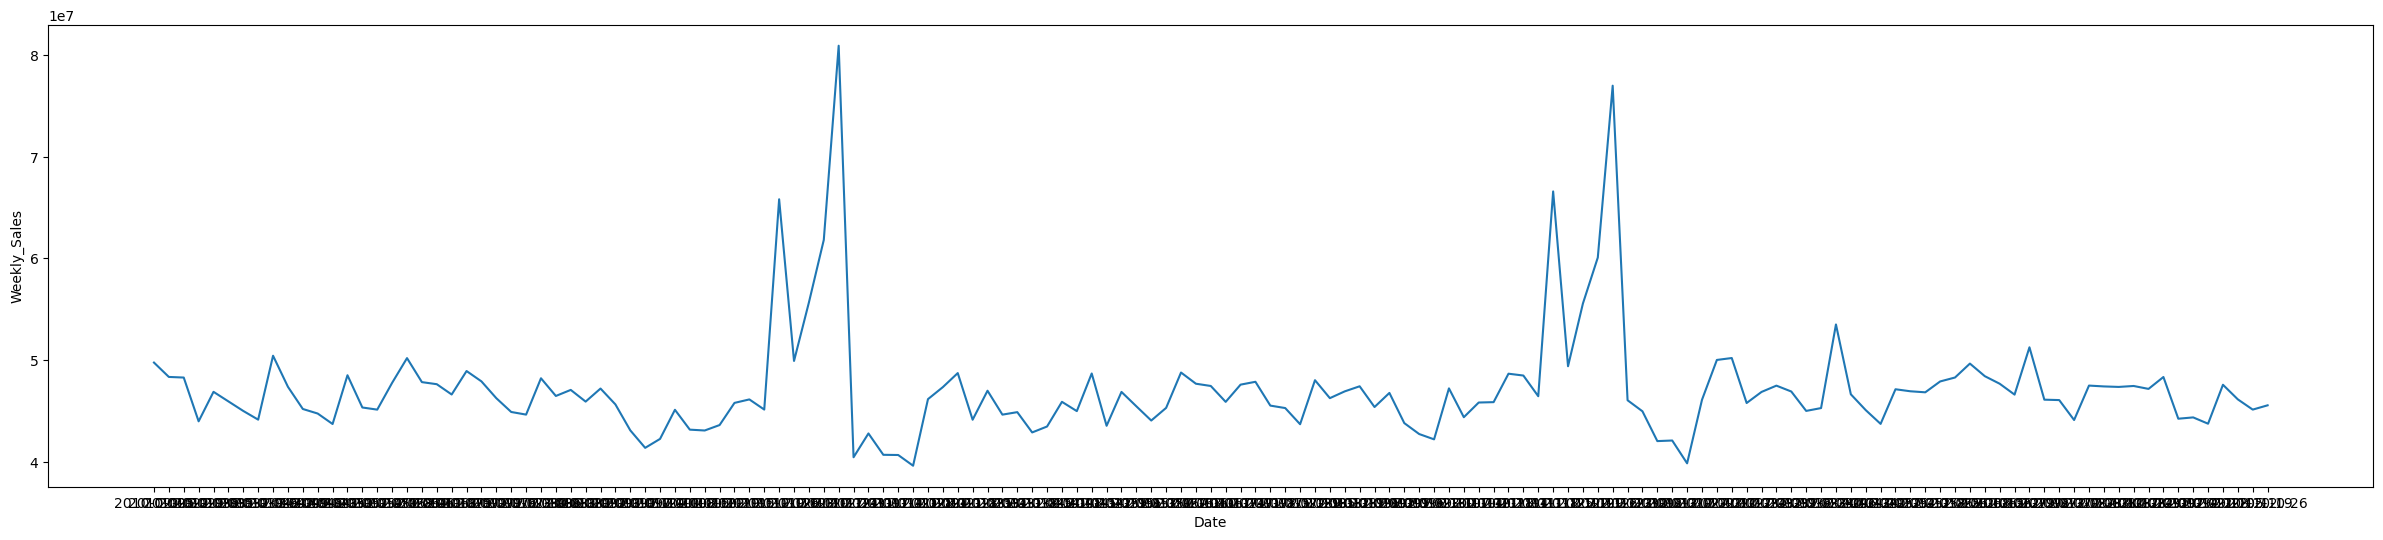

In [14]:
# 週別の売上推移を確認
plt.figure(figsize=(30,6))
df_tmp = df_train.groupby("Date").sum().reset_index()
sns.lineplot(x="Date", y="Weekly_Sales", data=df_tmp)
plt.show()

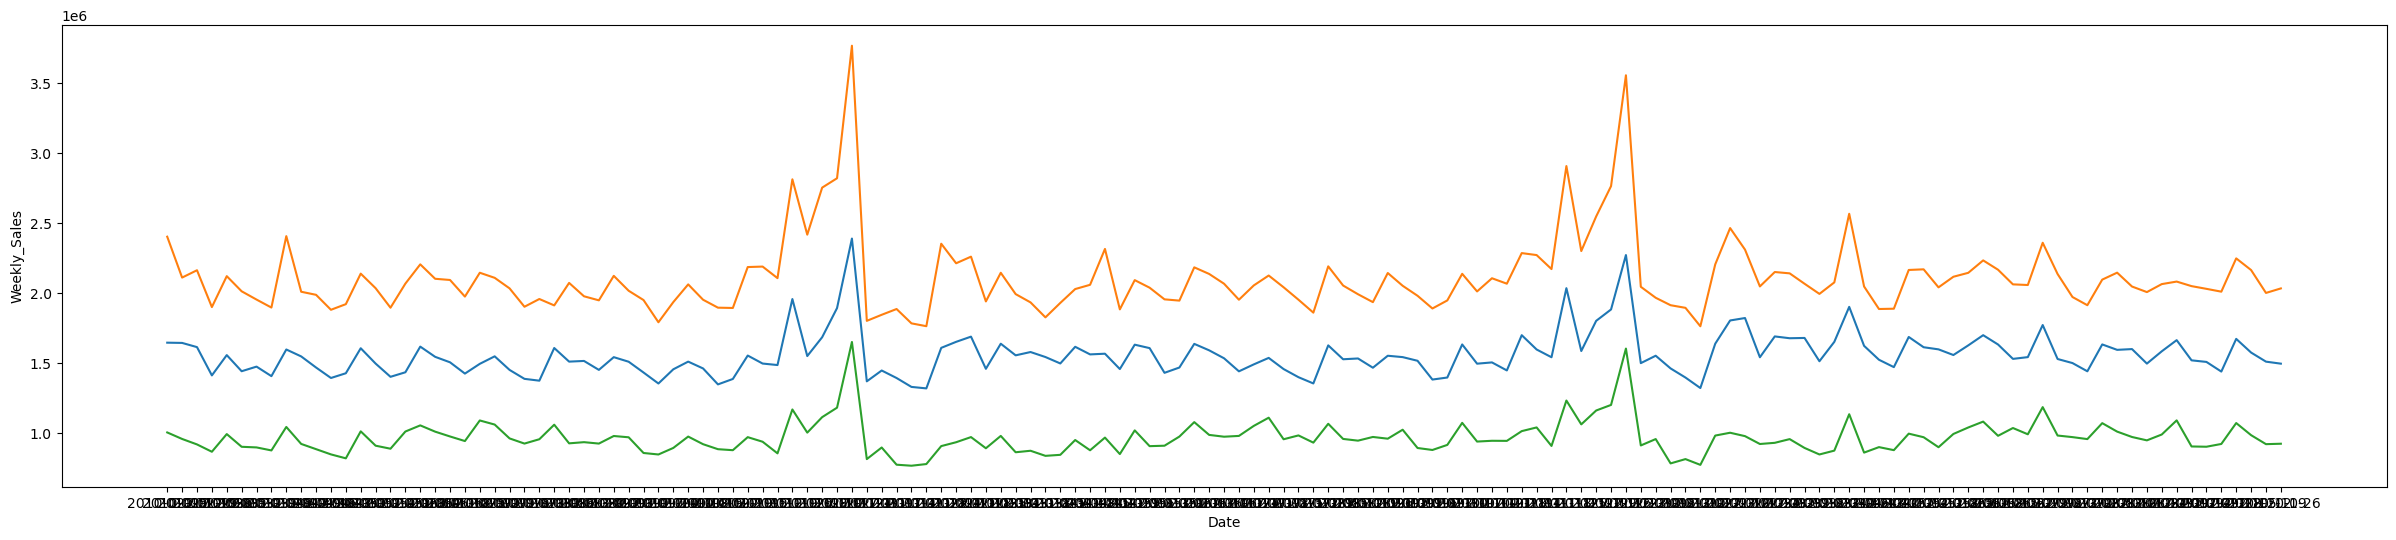

In [15]:
# 週別の売上推移を確認
plt.figure(figsize=(30,6))
df_tmp = df_train.groupby(["Date","Store"]).sum().reset_index()
sns.lineplot(x="Date", y="Weekly_Sales", data=df_tmp[df_tmp["Store"]==1])
sns.lineplot(x="Date", y="Weekly_Sales", data=df_tmp[df_tmp["Store"]==20])
sns.lineplot(x="Date", y="Weekly_Sales", data=df_tmp[df_tmp["Store"]==40])
plt.show()

In [16]:
# 売上の高い週順に並べる
df_tmp = df_train.groupby("Date").sum().reset_index()
df_tmp.sort_values("Weekly_Sales", ascending=False).head(10)

,Date,Store,Dept,Weekly_Sales,IsHoliday
46,2010-12-24,65507,130460,80931415.60,0
98,2011-12-23,67073,135571,76998241.31,0
94,2011-11-25,66864,135801,66593605.26,3021
42,2010-11-26,65217,129373,65821003.24,2938
45,2010-12-17,65676,130438,61820799.85,0
97,2011-12-16,66894,134714,60085695.94,0
44,2010-12-10,65354,129960,55666770.39,0
96,2011-12-09,66809,134656,55561147.70,0
113,2012-04-06,66323,132587,53502315.87,0
126,2012-07-06,65939,132367,51253021.88,0


In [17]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [18]:
import lightgbm as lgb
df = pd.merge(pd.merge(df_train, stores), feature)

In [19]:
#月の中で上旬・中旬・下旬を分ける
def term_class(x):
    if int(x[8:10])<10:
        term = 1
    elif int(x[8:10])<20:
        term = 2
    else:
        term = 3
    return term

#前処理
def preprocess(df):
    #月データ
    df["month"] = df["Date"].apply(lambda x:x[5:7])

    #月の中で上旬・中旬・下旬を分ける
    df["term"] = df["Date"].apply(term_class)
    
    #LightGBM用にカテゴリ化
    for col in ["Store", "Dept", "Type", "month", "term"]:
        df[col] = df[col].astype("category")
    
    return df

In [20]:

df = preprocess(df)

In [21]:
# 学習データと検証データに分類する
df_val = df[df["Date"] >= "2012-07-13"]
df_tr = df[df["Date"] < "2012-07-13"]

In [22]:
# 説明変数と目的変数に分ける
#　※動画内ではどちらもdf_valとなってしまっております。混乱を招き大変申し訳ございません
df_val_x = df_val.drop(["Weekly_Sales", "Date"], axis=1)
df_tr_x = df_tr.drop(["Weekly_Sales", "Date"], axis=1)
df_val_y = df_val["Weekly_Sales"]
df_tr_y = df_tr["Weekly_Sales"]

In [23]:
# LightGBM用のデータセット
trains = lgb.Dataset(df_tr_x, df_tr_y)
valids = lgb.Dataset(df_val_x, df_val_y)

In [24]:
# パラメータ
params = {
    "objective": "regression",
    "metric": "mae"
}

In [25]:
# モデル構築
model = lgb.train(params, trains, valid_sets=valids, num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=100)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 374203, number of used features: 16
[LightGBM] [Info] Start training from score 16031.684848
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's l1: 1706.21


In [26]:
df_te = pd.merge(pd.merge(df_test, stores), feature)

In [27]:
df_te = preprocess(df_te)

In [28]:
preds = model.predict(df_te.drop("Date", axis=1))

In [29]:
df_te = pd.concat([df_te, pd.DataFrame(preds)], axis=1).rename(columns={0:"Weekly_Sales"})

In [30]:
submit["Weekly_Sales"] = df_te.sort_values(["Store", "Dept", "Date"])["Weekly_Sales"]

In [31]:
submit.to_csv("submit.csv", index=False)